In [1]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr
import google.generativeai
import time

In [2]:
system_message = "You are a Comic artist called ComicCrafterAI. "
system_message += "Your Goal is to generate a comic book style short story based on user-provided prompts "
system_message += "The Story is divided into four parts: introduction, storyline, climax and moral of the story"

In [3]:
gemma2b = OpenAI(
    base_url="http://127.0.0.1:5000/v1",
    api_key="lm-studio"
)

In [4]:
import websocket #NOTE: websocket-client (https://github.com/websocket-client/websocket-client)
import uuid
import json
import urllib.request
import urllib.parse

def generate_image(message):
    server_address = "127.0.0.1:8188"
    client_id = str(uuid.uuid4())

    def queue_prompt(prompt):
        p = {"prompt": prompt, "client_id": client_id}
        data = json.dumps(p).encode('utf-8')
        req =  urllib.request.Request("http://{}/prompt".format(server_address), data=data)
        return json.loads(urllib.request.urlopen(req).read())

    def get_image(filename, subfolder, folder_type):
        data = {"filename": filename, "subfolder": subfolder, "type": folder_type}
        url_values = urllib.parse.urlencode(data)
        with urllib.request.urlopen("http://{}/view?{}".format(server_address, url_values)) as response:
            return response.read()

    def get_history(prompt_id):
        with urllib.request.urlopen("http://{}/history/{}".format(server_address, prompt_id)) as response:
            return json.loads(response.read())

    def get_images(ws, prompt):
        prompt_id = queue_prompt(prompt)['prompt_id']
        output_images = {}
        while True:
            out = ws.recv()
            if isinstance(out, str):
                message = json.loads(out)
                if message['type'] == 'executing':
                    data = message['data']
                    if data['node'] is None and data['prompt_id'] == prompt_id:
                        break #Execution is done
            else:
                # If you want to be able to decode the binary stream for latent previews, here is how you can do it:
                 #bytesIO = BytesIO(out[8:])
                 #preview_image = Image.open(bytesIO) # This is your preview in PIL image format, store it in a global
                 continue #previews are binary data

        history = get_history(prompt_id)[prompt_id]
        for node_id in history['outputs']:
            node_output = history['outputs'][node_id]
            images_output = []
            if 'images' in node_output:
                for image in node_output['images']:
                    image_data = get_image(image['filename'], image['subfolder'], image['type'])
                    images_output.append(image_data)
            output_images[node_id] = images_output

        return output_images


    prompt_text = """
    {
      "3": {
        "inputs": {
          "seed": 39904799525456,
          "steps": 25,
          "cfg": 7.3,
          "sampler_name": "euler",
          "scheduler": "normal",
          "denoise": 1,
          "model": [
            "4",
            0
          ],
          "positive": [
            "6",
            0
          ],
          "negative": [
            "7",
            0
          ],
          "latent_image": [
            "5",
            0
          ]
        },
        "class_type": "KSampler",
        "_meta": {
          "title": "KSampler"
        }
      },
      "4": {
        "inputs": {
          "ckpt_name": "v1-5-pruned-emaonly-fp16.safetensors"
        },
        "class_type": "CheckpointLoaderSimple",
        "_meta": {
          "title": "Load Checkpoint"
        }
      },
      "5": {
        "inputs": {
          "width": 512,
          "height": 512,
          "batch_size": 1
        },
        "class_type": "EmptyLatentImage",
        "_meta": {
          "title": "Empty Latent Image"
        }
      },
      "6": {
        "inputs": {
          "text": "An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
          "clip": [
            "4",
            1
          ]
        },
        "class_type": "CLIPTextEncode",
        "_meta": {
          "title": "CLIP Text Encode (Prompt)"
        }
      },
      "7": {
        "inputs": {
          "text": "text, watermark",
          "clip": [
            "4",
            1
          ]
        },
        "class_type": "CLIPTextEncode",
        "_meta": {
          "title": "CLIP Text Encode (Prompt)"
        }
      },
      "8": {
        "inputs": {
          "samples": [
            "3",
            0
          ],
          "vae": [
            "4",
            2
          ]
        },
        "class_type": "VAEDecode",
        "_meta": {
          "title": "VAE Decode"
        }
      },
      "9": {
        "inputs": {
          "filename_prefix": "ComfyUI",
          "images": [
            "8",
            0
          ]
        },
        "class_type": "SaveImage",
        "_meta": {
          "title": "Save Image"
        }
      }
    } 
    """
    prompt = json.loads(prompt_text)

    #set the text prompt for our positive CLIPTextEncode
    prompt["6"]["inputs"]["text"] = f"Generate a comic style images with four compartments according to this story : {message}"
    prompt["7"]["inputs"]["text"] = "Distorted image, unclear image, dull image , colorless image, grayscale image, out of frame , text, watermark"

    seednum = prompt["3"]["inputs"]["seed"]
    #set the seed for our KSampler node
    prompt["3"]["inputs"]["seed"] = seednum

    ws = websocket.WebSocket()
    ws.connect("ws://{}/ws?clientId={}".format(server_address, client_id))
    images = get_images(ws, prompt)
    ws.close() # for in case this example is used in an environment where it will be repeatedly called, like in a Gradio app. otherwise, you'll randomly receive connection timeouts
    #Commented out code to display the output images:

    for node_id in images:
        for image_data in images[node_id]:
            from PIL import Image
            import io
            return(Image.open(io.BytesIO(image_data)))


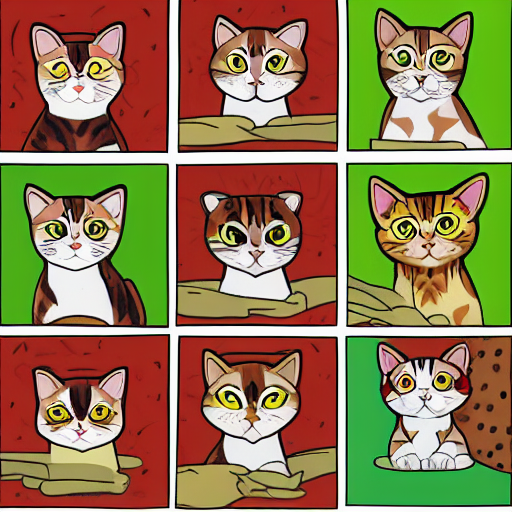

In [5]:
image = generate_image("a cat")
display(image)

In [6]:
def chat_local_streaming(message):
    messages = [{"role": "system", "content": system_message},
                {"role": "user", "content": message}]
    response = gemma2b.chat.completions.create(
        model="gemma-2-2b-it",
        messages=messages,
        temperature=0.9,
        stream=True  
    )
    reply = ""
    yield reply, gr.update(value=None, visible=True, label="Processing...")  
    for chunk in response:
        text = chunk.choices[0].delta.content
        if text:
            reply += text
            yield reply, gr.update(value=None, visible=True, label="Processing...")  
    image = generate_image(reply)
    yield reply, gr.update(value=image, visible=True, label="Comic image")  

In [7]:
with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500, label="Comic image", visible=False) 
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role": "user", "content": message}]
        response_gen = chat_local_streaming(message)
        reply = ""
        image = None
        for output in response_gen:
            if isinstance(output, tuple):
                reply, image = output
            else:
                reply = output
            yield "", history + [{"role": "assistant", "content": reply}], image

    entry.submit(
        do_entry,
        inputs=[entry, chatbot],
        outputs=[entry, chatbot, image_output]
    )
    clear.click(lambda: ([], gr.update(value=None, visible=False)), inputs=None, outputs=[chatbot, image_output], queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
